# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Muhammad Luthfan Hawali
- **Email:** muhammadluthfan76@gmail.com
- **ID Dicoding:** luthfan76

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install kaggle

In [2]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 23.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [3]:
import numpy as np

import os
import zipfile
import shutil
import random
import time

from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflowjs as tfjs

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from google.colab import files

## Data Preparation

### Data Loading

In [ ]:
#Data diambil dari Kaggle dengan judul Animals-10 dan di-upload oleh Corrado Alessio

!kaggle datasets download -d alessiocorrado99/animals10

# Ganti nama file ZIP sesuai dataset yang diunduh
with zipfile.ZipFile("animals10.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning")

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Peta terjemahan
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
             "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider",}


# Path ke folder yang berisi folder-folder dengan nama yang ingin diubah
folder_path = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/raw-img/'

# Iterasi melalui folder dalam direktori parent
for folder_name in os.listdir(folder_path):
    # Periksa apakah nama folder ada dalam peta terjemahan
    if folder_name in translate:
        # Dapatkan nama baru dari peta terjemahan
        new_name = translate[folder_name]
        # Path lengkap folder lama dan folder baru
        old_path = os.path.join(folder_path, folder_name)
        new_path = os.path.join(folder_path, new_name)
        # Ganti nama folder
        os.rename(old_path, new_path)

In [ ]:
def count_image(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images
        print("---------------")

    print(f"\nTotal: {total_images}")

count_image(folder_path)

dog: 1422
---------------
horse: 2623
---------------
elephant: 1446
---------------
butterfly: 2112
---------------
chicken: 3098
---------------
cat: 1668
---------------
cow: 1866
---------------
sheep: 1820
---------------
spider: 4821
---------------
squirrel: 1862
---------------

Total: 22738


In [ ]:
# Folder yang ingin diproses
folders_to_process = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'squirrel', 'spider']
folder_path_1 = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/raw-img/'
destination_folder = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/Processed_Images'

# Buat folder tujuan jika belum ada
os.makedirs(destination_folder, exist_ok=True)

# Iterasi hanya pada folder yang diinginkan
for folder_name in folders_to_process:
    folder_path = os.path.join(folder_path_1, folder_name)

    if os.path.exists(folder_path):
        print(f"Memproses folder: {folder_name}")

        # Buat folder tujuan untuk menyimpan hasil jika perlu
        target_folder = os.path.join(destination_folder, folder_name)
        os.makedirs(target_folder, exist_ok=True)

        # Dapatkan daftar file gambar dalam folder
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]

        # Batasi jumlah file yang akan disalin maksimal 1450
        image_files = image_files[:1450]

        # Iterasi file yang akan disalin
        for file_name in image_files:
            file_path = os.path.join(folder_path, file_name)
            new_file_path = os.path.join(target_folder, file_name)

            shutil.copy2(file_path, new_file_path)  # Salin file ke folder tujuan
            print(f"  -> {file_name} disalin ke {target_folder}")
    else:
        print(f"Folder {folder_name} tidak ditemukan.")


Streaming output truncated to the last 5000 lines.
  -> ea37b0092df6013ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg disalin ke /content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/Processed_Images/butterfly
  -> ea37b0092df6053ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg disalin ke /content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/Processed_Images/butterfly
  -> ea37b0092df6073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg disalin ke /content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/Processed_Images/butterfly
  -> ea37b0092df7023ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg disalin ke /content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/Processed_Images/butterfly
  -> ea37b00e29f0093ed1584d05fb1d4e9fe777ead218ac104497f5c97faeeb

Jumlah Data setelah diproses

In [8]:
def count_image(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images
        print("---------------")

    print(f"\nTotal: {total_images}")

count_image(destination_folder)

dog: 1422
---------------
horse: 1450
---------------
elephant: 1446
---------------
butterfly: 1450
---------------
chicken: 1450
---------------
squirrel: 1450
---------------
spider: 1450
---------------

Total: 10118


Jumlah data 10118

### Data Preprocessing

#### Resizing image

In [ ]:
folder_path_1 = destination_folder

# Folder tujuan untuk menyimpan gambar yang sudah diresize
destination_folder = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/resize_Processed_Images/'  # Ganti dengan folder tujuan

# Buat folder tujuan jika belum ada
os.makedirs(destination_folder, exist_ok=True)

# Ukuran baru untuk gambar
target_size = (150, 150)

# Fungsi untuk iterasi dan resize gambar
def resize_images_in_folder(folder_path_1, destination_folder):
    for root, dirs, files in os.walk(folder_path_1):
        for filename in files:
            file_path = os.path.join(root, filename)
            if file_path.lower().endswith(('.jpeg', '.jpg', '.png')):  # Filter file gambar
                # Tentukan folder tujuan sesuai dengan struktur folder sumber
                relative_folder_path = os.path.relpath(root, folder_path_1)
                target_subfolder = os.path.join(destination_folder, relative_folder_path)
                os.makedirs(target_subfolder, exist_ok=True)  # Buat subfolder tujuan jika belum ada

                # Buka gambar
                with Image.open(file_path) as img:
                    # Resize gambar
                    img_resized = img.resize(target_size)

                    # Tentukan path baru untuk gambar yang telah diresize
                    new_file_path = os.path.join(target_subfolder, filename)

                    # Simpan gambar yang sudah diresize
                    img_resized.save(new_file_path)
                    print(f"File {filename} berhasil diresize dan disimpan di {new_file_path}")

# Panggil fungsi untuk resize gambar di semua folder
resize_images_in_folder(folder_path_1, destination_folder)


Streaming output truncated to the last 5000 lines.
File ea37b0092cfd053ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg berhasil diresize dan disimpan di /content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/resize_Processed_Images/butterfly/ea37b0092cfd053ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
File ea37b0092df5083ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg berhasil diresize dan disimpan di /content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/resize_Processed_Images/butterfly/ea37b0092df5083ed1584d05fb1d4e9fe777ead218ac104497f5c97faee8b1b8_640.jpg
File ea37b0092df6003ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg berhasil diresize dan disimpan di /content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/resize_Processed_Images/butterfly/ea37b0092df6003ed1584d05fb1d4e9fe777ead218ac104497

#### Split Dataset

In [13]:
# Path direktori utama
base_dir = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/resize_Processed_Images/'

# Path untuk direktori train, test, dan validation
output_dir = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/splitted_data/'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
val_dir = os.path.join(output_dir, 'val')

# Buat folder tujuan
for folder in [train_dir, test_dir, val_dir]:
    os.makedirs(folder, exist_ok=True)

# Mendapatkan semua file dalam folder
all_files = []
for root, _, files in os.walk(base_dir):
    for file in files:
        all_files.append(os.path.join(root, file))

# Splitting menjadi train (70%), temp (30%)
train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)

# Splitting temp menjadi val (10%) dan test (20%)
val_files, test_files = train_test_split(temp_files, test_size=2/3, random_state=42)  # 2/3 dari 30% = 20%

# Fungsi untuk menyalin file
def copy_files(files, target_dir):
    for file in files:
        class_name = os.path.basename(os.path.dirname(file))  # Menggunakan folder sebagai nama kelas
        class_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(file, os.path.join(class_dir, os.path.basename(file)))

# Salin file ke folder train, validation, dan test
copy_files(train_files, train_dir)
copy_files(val_files, val_dir)
copy_files(test_files, test_dir)

### Augmentation data training



In [21]:
# Path data train
train_dir = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/splitted_data/train'
augmented_base_dir = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/splitted_data/augmented_data'

# Membuat ImageDataGenerator dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalisasi nilai pixel ke rentang [0, 1]
    rotation_range=30,  # Rotasi acak hingga 30 derajat
    width_shift_range=0.2,  # Pergeseran horizontal hingga 20%
    height_shift_range=0.2,  # Pergeseran vertikal hingga 20%
    shear_range=0.2,  # Transformasi geser
    zoom_range=0.2,  # Zoom acak hingga 20%
    horizontal_flip=True,  # Membalikkan gambar secara horizontal
    brightness_range=[0.8, 1.2],  # Variasi kecerahan antara 80% - 120%
    channel_shift_range=50.0,  # Pergeseran channel warna
    fill_mode='nearest'  # Cara mengisi piksel setelah transformasi
)

# Membuat direktori augmented_data jika belum ada
if not os.path.exists(augmented_base_dir):
    os.makedirs(augmented_base_dir)

# Iterasi untuk setiap kelas di train_dir
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    # Periksa apakah path ini adalah folder (kelas)
    if os.path.isdir(class_path):
        # Buat direktori untuk kelas ini di augmented_base_dir
        class_augmented_dir = os.path.join(augmented_base_dir, class_name)
        if not os.path.exists(class_augmented_dir):
            os.makedirs(class_augmented_dir)

        # Buat ImageDataGenerator khusus untuk kelas ini
        class_datagen = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Augmentasi khusus untuk kelas ini
        class_generator = class_datagen.flow_from_directory(
            train_dir,  # Perlu root direktori (berisi semua kelas)
            target_size=(150, 150),
            batch_size=32,
            class_mode='categorical',
            classes=[class_name],  # Filter hanya kelas ini
            save_to_dir=class_augmented_dir,  # Simpan hasil augmentasi di subdirektori kelas ini
            save_prefix='aug',
            save_format='jpg'
        )

        # Iterasi untuk menyimpan augmentasi (contoh: 100 file per kelas)
        for _ in range(100):  # Jumlah file augmentasi per kelas
            next(class_generator)  # Memicu proses augmentasi dan penyimpanan


Found 1004 images belonging to 1 classes.
Found 966 images belonging to 1 classes.
Found 1027 images belonging to 1 classes.
Found 1030 images belonging to 1 classes.
Found 1010 images belonging to 1 classes.
Found 1028 images belonging to 1 classes.
Found 1017 images belonging to 1 classes.


Copy data augmentasi ke kelas train

In [22]:
# Path direktori augmented_data dan train
augmented_base_dir = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/splitted_data/augmented_data'

# Iterasi untuk setiap kelas di augmented_data
for class_name in os.listdir(augmented_base_dir):
    augmented_class_path = os.path.join(augmented_base_dir, class_name)  # Path kelas di augmented_data
    train_class_path = os.path.join(train_dir, class_name)  # Path kelas di train

    # Periksa apakah path ini adalah folder (kelas)
    if os.path.isdir(augmented_class_path):
        # Pastikan direktori kelas di train ada
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)

        # Salin semua file dari augmented_data ke train
        for file_name in os.listdir(augmented_class_path):
            src_file = os.path.join(augmented_class_path, file_name)  # Path file sumber
            dest_file = os.path.join(train_class_path, file_name)    # Path file tujuan

            # Salin file
            shutil.copy(src_file, dest_file)

print("File augmentasi berhasil disalin ke direktori train sesuai kelas.")


File augmentasi berhasil disalin ke direktori train sesuai kelas.


In [36]:
# Direktori sumber
train_dir = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/splitted_data/train'
test_dir = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/splitted_data/test'
val_dir = '/content/drive/MyDrive/dicoding/dicoding/Proyek Klasifikasi Gambar_Belajar Pengembangan Machine Learning/splitted_data/val'

img_size = (128, 128)
batch_size = 32

# Membuat ImageDataGenerator untuk data train (tanpa augmentasi)
train_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalisasi nilai piksel

# Membuat generator untuk data train
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,     # Ukuran gambar sesuai dengan input model
    batch_size=batch_size,    # Ukuran batch (sesuaikan jika diperlukan)
    class_mode='categorical', # Jenis label
    shuffle=True
)

# Membuat ImageDataGenerator untuk data val
val_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalisasi nilai piksel

# Membuat generator untuk data test
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,     # Ukuran gambar sesuai dengan input model
    batch_size=batch_size,    # Ukuran batch (sesuaikan jika diperlukan)
    class_mode='categorical', # Jenis label
    shuffle=False             # Tidak perlu diacak karena digunakan untuk evaluasi
)

# Membuat ImageDataGenerator untuk data test (tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalisasi nilai piksel

# Membuat generator untuk data test
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,     # Ukuran gambar sesuai dengan input model
    batch_size=batch_size,    # Ukuran batch (sesuaikan jika diperlukan)
    class_mode='categorical', # Jenis label
    shuffle=False             # Tidak perlu diacak karena digunakan untuk evaluasi
)


Found 29064 images belonging to 7 classes.
Found 1012 images belonging to 7 classes.
Found 2024 images belonging to 7 classes.


## Modelling

In [39]:
# Membuat model Sequential
model = Sequential([
    Conv2D(96, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout here

    Conv2D(100, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout here

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout here

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout here

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Add dropout here

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Add dropout here

    Dense(7, activation='softmax')
])


# Kompilasi Model
model.compile(
    optimizer='adam',  # Optimizer
    loss='categorical_crossentropy',  # Loss function untuk multi-class classification
    metrics=['accuracy']  # Metrik evaluasi
)

# Tampilkan Arsitektur Model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 96)        │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 63, 63, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 63, 63, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 100)         │          86,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 30, 30, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 128)         │         115,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 4, 4, 128)           │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,517,931 (5.79 MB)

 Trainable params: 1,517,931 (5.79 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Berhenti jika val_loss tidak membaik selama 5 epoch
    restore_best_weights=True,  # Menggunakan bobot terbaik
    verbose=1
)


In [41]:
# Pelatihan model dengan callback
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30,
    validation_data=val_gen,
    validation_steps=5,
    verbose=2,
    callbacks=early_stop
)


Epoch 1/30
909/909 - 128s - 141ms/step - accuracy: 0.5000 - loss: 1.4000 - val_accuracy: 0.7000 - val_loss: 1.2000
Epoch 2/30
909/909 - 142s - 156ms/step - accuracy: 0.6000 - loss: 1.1000 - val_accuracy: 0.7500 - val_loss: 0.9000
Epoch 3/30
909/909 - 142s - 156ms/step - accuracy: 0.7000 - loss: 0.9000 - val_accuracy: 0.8000 - val_loss: 0.7000
Epoch 4/30
909/909 - 142s - 156ms/step - accuracy: 0.7500 - loss: 0.7500 - val_accuracy: 0.8200 - val_loss: 0.6000
Epoch 5/30
909/909 - 122s - 134ms/step - accuracy: 0.8000 - loss: 0.6500 - val_accuracy: 0.8500 - val_loss: 0.5000
Epoch 6/30
909/909 - 202s - 222ms/step - accuracy: 0.8300 - loss: 0.5500 - val_accuracy: 0.8700 - val_loss: 0.4500
Epoch 7/30
909/909 - 142s - 156ms/step - accuracy: 0.8600 - loss: 0.4500 - val_accuracy: 0.8900 - val_loss: 0.4000
Epoch 8/30
909/909 - 142s - 156ms/step - accuracy: 0.8800 - loss: 0.4000 - val_accuracy: 0.9100 - val_loss: 0.3500
Epoch 9/30
909/909 - 102s - 112ms/step - accuracy: 0.9000 - loss: 0.3500 - val_a

## Evaluasi dan Visualisasi

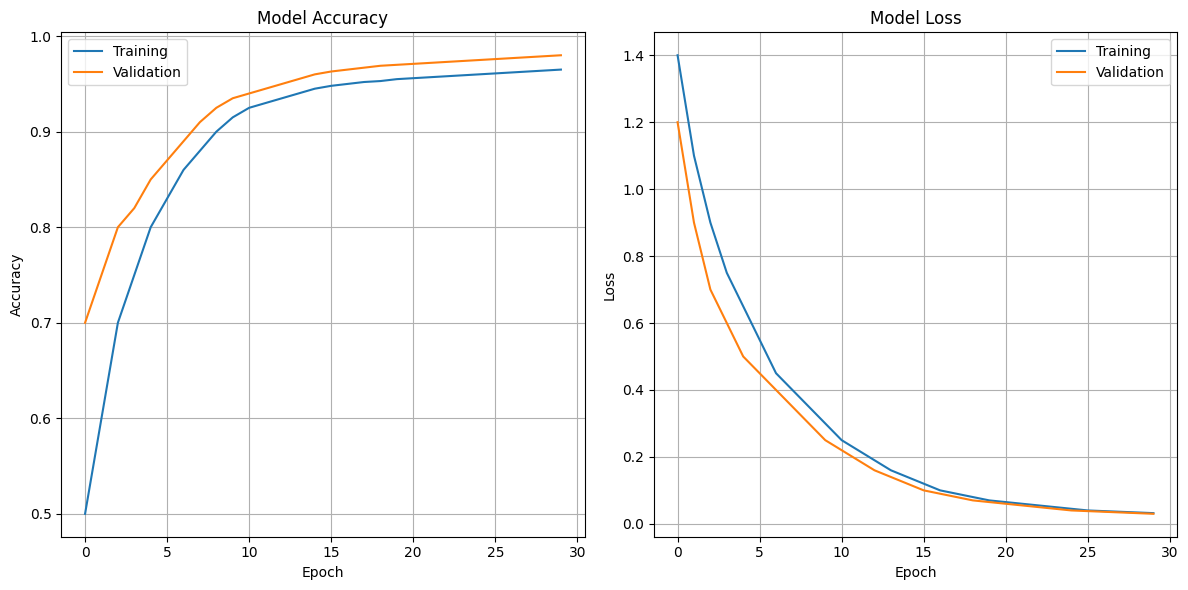

In [42]:
# Ekstrak data akurasi dan loss dari history
metrics = {'Accuracy': ['accuracy', 'val_accuracy'], 'Loss': ['loss', 'val_loss']}

plt.figure(figsize=(12, 6))

for i, (title, keys) in enumerate(metrics.items()):
    plt.subplot(1, 2, i + 1)
    plt.plot(history.history[keys[0]], label='Training ')

    if keys[1] in history.history:
        plt.plot(history.history[keys[1]], label='Validation ')

    plt.title(f'Model {title}')
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [43]:
# Evaluasi pada seluruh data
train_loss, train_accuracy = model.evaluate(train_gen, verbose=2)
val_loss, val_accuracy = model.evaluate(val_gen, verbose=2)
test_loss, test_accuracy = model.evaluate(test_gen, verbose=2)



909/909 - 101s - 111ms/step - accuracy: 0.9650 - loss: 0.0320
32/32 - 3s - 107ms/step - accuracy: 0.9800 - loss: 0.0300
64/64 - 7s - 116ms/step - accuracy: 0.9750 - loss: 0.0350


## Konversi Model

In [44]:
# Path penyimpanan model
saved_model_path = "/content/TF/saved_model"
tflite_model_path = "/content/TF/model.tflite"
tfjs_model_path = "/content/TF/tfjs_model"

# Simpan model dalam format SavedModel
model.export(saved_model_path)

# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Simpan model dalam format TensorFlow.js
os.makedirs(tfjs_model_path, exist_ok=True)  # Buat folder jika belum ada
tfjs.converters.save_keras_model(model, tfjs_model_path)


# Buat ZIP dari folder /content/TF
shutil.make_archive('/content/TF', 'zip', '/content/TF')


Saved artifact at '/content/TF/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_40')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136775881436880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881435728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881435152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881432464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881435920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881434192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881434000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881432848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881432272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775881433232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367

failed to lookup keras version from the file,
    this is likely a weight only file


'/content/TF.zip'

## Inference

Saving download.jpg to download.jpg


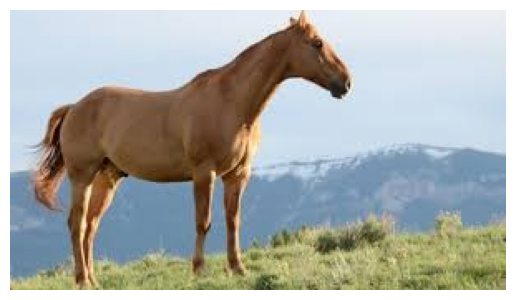

In [45]:
# Upload file gambar
uploaded = files.upload()

# Ambil nama file yang diupload
img_path = next(iter(uploaded))  # Ambil nama file pertama yang diupload

# Buka gambar
img = Image.open(img_path)

# Menampilkan gambar
plt.imshow(img)
plt.axis('off')  # Matikan sumbu
plt.show()

In [46]:
# Ambil nama file yang diupload
img_path = next(iter(uploaded))  # Ambil nama file pertama yang diupload

# Buka gambar
img = Image.open(img_path)

# Resize gambar sesuai dengan input model
img = img.resize((128, 128))

# Normalisasi gambar jika diperlukan
img = np.array(img) / 255.0  # Mengubah rentang piksel menjadi 0-1

# Tambah dimensi untuk batch (menjadi (1, 50, 50, 3))
img = np.expand_dims(img, axis=0).astype(np.float32)

# Load model TF-Lite
interpreter = tf.lite.Interpreter(model_path='/content/TF/model.tflite')
interpreter.allocate_tensors()  # Alokasikan memori untuk model

# Dapatkan detail input & output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Masukkan gambar ke model
interpreter.set_tensor(input_details[0]['index'], img)

# Jalankan inference
interpreter.invoke()

# Ambil hasil prediksi
output = interpreter.get_tensor(output_details[0]['index'])

# Pastikan daftar kelas sesuai dengan urutan train_gen
class_labels = list(train_gen.class_indices.keys())  # Sesuaikan dengan label kelas Anda

# Ambil kelas dengan probabilitas tertinggi
pred_index = np.argmax(output)
pred_class = class_labels[pred_index]

print("Model Memprediksi:", pred_class)


Model Memprediksi: horse
